# Analyse de la qualité des données

## Prise de connaissance avec le jeu de données

### Chargement des données brut

In [103]:
from getting_started import df_patient, df_pcr, pd

Conversion de chaque attribut du référentiel en un type de données plus spécifique.

In [105]:
df_patient = df_patient.convert_dtypes()

df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient_id     20000 non-null  Int64 
 1   given_name     19560 non-null  string
 2   surname        19575 non-null  string
 3   street_number  19618 non-null  Int64 
 4   address_1      19204 non-null  string
 5   suburb         19788 non-null  string
 6   postcode       19801 non-null  string
 7   state          18010 non-null  string
 8   date_of_birth  17989 non-null  Int64 
 9   age            16003 non-null  Int64 
 10  phone_number   19081 non-null  string
 11  address_2      7893 non-null   string
dtypes: Int64(4), string(8)
memory usage: 1.9 MB


Conversion de chaque attribut de l'échantillon en un type de données plus spécifique.

In [107]:
df_pcr = df_pcr.convert_dtypes()

df_pcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  8800 non-null   Int64 
 1   pcr         8800 non-null   string
dtypes: Int64(1), string(1)
memory usage: 146.2 KB


### Présence de doublons sur l'identifiant

In [109]:
with_duplicated_id = df_patient.patient_id.duplicated(keep=False)

df_patient[with_duplicated_id].sort_values("patient_id")

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
12117,109304,zachary,farronato,30,outtrim avenue,como,2196,vic,19090801,31,07 22894061,the reefs
14839,109304,bailey,donaldson,20,tardent street,ryde,0812,qld,19580310,26,07 13479210,<NA>
4386,110207,toby,brock,4,merriman crescent,baralaba,3025,nsw,19000424,35,08 33842007,leitrim
12989,110207,zali,brock,32,hedger street,toorak,5038,act,<NA>,22,08 96818512,<NA>
10184,115791,hannah,clarke,70,galmarra street,mayfield,7010,vic,19830828,25,04 70760611,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
10507,990695,erin,braunack,49,moondarra street,broken hill,2640,qld,19830122,30,03 69523317,yuulong
8764,990936,amy,royle,90,whittell crescent,coramba,5032,sa,19950326,<NA>,08 07309295,tewantin plaza
12563,990936,samantha,green,21,brierly street,ardrossan,2140,<NA>,19380210,29,02 51600621,<NA>
2385,994235,trent,stewart-jones,129,macfarland crescent,wangaratta,2732,nsw,<NA>,<NA>,07 98662458,mountview


Il y a 403 patients qui doublonnent sur l'identifiant.

### Présence de doublons sur l'ensemble des attributs

In [111]:
with_same_attributes = df_patient.drop(columns="patient_id").duplicated(keep=False)

df_patient[with_same_attributes].sort_values(by=["surname", "given_name"])

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
6981,804259,charlie,gamlin,33,nungara street,bayswater,5251,qld,19190111,24,04 33326042,<NA>
12438,107928,charlie,gamlin,33,nungara street,bayswater,5251,qld,19190111,24,04 33326042,<NA>
15184,744576,freya,jaffres,50,hart place,biggera waters,4413,wa,<NA>,33,07 76055136,<NA>
17522,449738,freya,jaffres,50,hart place,biggera waters,4413,wa,<NA>,33,07 76055136,<NA>
5729,973030,delaney,kermeen,9,wallen place,st kilda east,4405,qld,19391226,25,08 37919311,<NA>
15337,373129,delaney,kermeen,9,wallen place,st kilda east,4405,qld,19391226,25,08 37919311,<NA>
1052,664037,samantha,laundy,2,mannheim street,quairading,4740,qld,19480111,<NA>,02 37735421,stanton
18867,421721,samantha,laundy,2,mannheim street,quairading,4740,qld,19480111,<NA>,02 37735421,stanton
1863,658924,lewis,matthews,24,allawah flats,attunga,3216,wa,19690623,26,03 95122427,<NA>
1944,669936,lewis,matthews,24,allawah flats,attunga,3216,wa,19690623,26,03 95122427,<NA>


Il y 22 patients qui doublonnent sur tous les attributs hors identifiant.

### Nombre d'attributs non renseignés par patient

<AxesSubplot:xlabel='attributs non renseignés', ylabel='patients'>

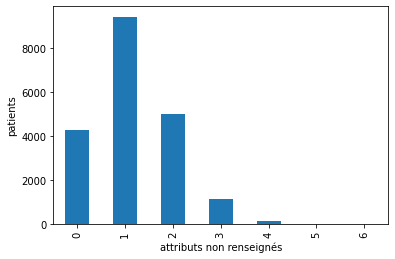

In [113]:
df_patient.isna().sum(axis="columns").value_counts().sort_index().plot.bar(xlabel="attributs non renseignés", ylabel="patients")

La majorité des patients ont jusqu'à 2 attributs non renseignés.

Il y aura des cas extrêmes à rapprocher avec 5 voire 6 attributs manquants.

### Répartition des valeurs du test PCR

In [115]:
df_pcr.pcr.value_counts()

N           3482
Negative    3134
Positive    1283
P            901
Name: pcr, dtype: Int64

Deux conventions sont utilisées pour représenter les deux valeurs possibles d'un test PCR (négatif ou positif) : `N / P` et `Negative / Positive`.

Il faudra normaliser ces résultats dans une variable catégorielle ordonnée.

### Exhaustivité du référentiel

In [117]:
df_pcr.patient_id.isin(df_patient.patient_id).all()

True

L'intégralité des identifiants associés aux tests de l'échantillon sont présents dans le référenciel.

## Analyse du référenciel de patients

### Nom et prénom

#### Valeurs manquantes

In [119]:
df_na_in_patient_name = df_patient[["surname", "given_name"]].isna()

df_na_in_patient_name.value_counts()

surname  given_name
False    False         19139
         True            436
True     False           421
         True              4
dtype: int64

Il y a 861 patients dont le nom et / ou prénom ne sont pas renseignés.

#### Fautes typographiques

In [121]:
from jellyfish import damerau_levenshtein_distance

df_patient["full_name"] = df_patient.agg(
    lambda x: f"{x.given_name} {x.surname}", axis="columns")

df_full_name = df_patient[["patient_id", "full_name", "phone_number"]].dropna()
df_full_name = df_full_name.merge(df_full_name, on="phone_number")
df_full_name = df_full_name[df_full_name.patient_id_x != df_full_name.patient_id_y]
df_full_name["linked_ids"] = df_full_name[["patient_id_x", "patient_id_y"]].apply(
    lambda row: tuple(sorted(row)), axis="columns")
df_full_name.drop_duplicates("linked_ids", inplace=True)
df_full_name["distance"] = df_full_name.apply(
    lambda row: damerau_levenshtein_distance(row.full_name_x, row.full_name_y), axis="columns")

df_full_name = df_full_name[df_full_name.distance >= 1]

Cette cellule procède à un rapprochement des patients partageant un même numéro de téléphone et calcule la similarité entre leurs noms complets sous forme d'une distance.

Le numéro de téléphone, quand il est fourni, est un attribut à forte valeur distinctive d'où son utilisation dans le cross-join.

La distance choisie est Damerau-Levenshtein car elle est particulièrement adaptée pour détecter les fautes humaines qui peuvent arriver lors de la saisie répétée de texte brut.

In [123]:
df_full_name[df_full_name.distance <= 2].sort_values("phone_number").head(20)

,patient_id_x,full_name_x,phone_number,patient_id_y,full_name_y,linked_ids,distance
4192,311830,taaila <NA>,02 00325977,210155,taalia <NA>,"(210155, 311830)",1
4193,311830,taaila <NA>,02 00325977,525466,taalia <NA>,"(311830, 525466)",1
990,123387,adam schumajnn,02 01272164,505218,adam schumann,"(123387, 505218)",1
991,123387,adam schumajnn,02 01272164,375877,adam schumann,"(123387, 375877)",1
985,431593,adam schumann,02 01272164,123387,adam schumajnn,"(123387, 431593)",1
1827,489678,jacob svenson,02 03546747,909797,jaob svenson,"(489678, 909797)",1
1831,669354,jacob svenson,02 03546747,909797,jaob svenson,"(669354, 909797)",1
1835,576055,jacob svenson,02 03546747,909797,jaob svenson,"(576055, 909797)",1
570,736584,<NA> petersen,02 03687263,399260,<NA> peterssen,"(399260, 736584)",1
574,950122,<NA> petersen,02 03687263,399260,<NA> peterssen,"(399260, 950122)",1


Dans le cas d'une distance faible, on retrouve les fautes typographiques suivantes :

- Ajout de caractère (schumajnn -> schumann)
- Omission de caractère (jaob -> jacob)
- Substitution de caractère (martincvic -> martinovic)
- Transposition de caractère (taaila -> taalia)

### Autres différences

In [125]:
df_full_name[df_full_name.distance > 2].sort_values("phone_number").head(20)

,patient_id_x,full_name_x,phone_number,patient_id_y,full_name_y,linked_ids,distance
6144,953966,to godfrey,02 01871708,405442,thomas godfrey,"(405442, 953966)",4
16219,382081,james <NA>,02 03755662,687453,jim <NA>,"(382081, 687453)",3
5702,970678,stacia seddon,02 05657798,963018,anastasia seddon,"(963018, 970678)",4
5705,496474,stacia seddon,02 05657798,963018,anastasia seddon,"(496474, 963018)",4
10877,898204,jordan ballantyne,02 13710140,494861,ballantyne jordan,"(494861, 898204)",14
10878,898204,jordan ballantyne,02 13710140,219095,<NA> ballantyne,"(219095, 898204)",6
10881,740337,jordan ballantyne,02 13710140,494861,ballantyne jordan,"(494861, 740337)",14
10886,494861,ballantyne jordan,02 13710140,219095,<NA> ballantyne,"(219095, 494861)",12
10882,740337,jordan ballantyne,02 13710140,219095,<NA> ballantyne,"(219095, 740337)",6
15131,414444,joshua white,02 14864045,388581,joshua wight,"(388581, 414444)",3


Pour les cas où la distance est plus forte, on relève d'autres différences :

- Faute lexicale (wight -> white)
- Diminutif du prénom (thomas -> to, anastasia -> stacia)
- Substitution du prénom (james -> jim, emiily -> millie)
- Inversion des nom et prénom
- Omission du prénom ou du nom

## Âge et date de naissance

### Valeurs manquantes

In [127]:
df_patient[["date_of_birth", "age"]].isna().value_counts()

date_of_birth  age  
False          False    14391
               True      3598
True           False     1612
               True       399
dtype: int64

### Répartition des âges

In [129]:
df_patient.age.describe()

count    16003.000000
mean        27.534337
std          7.807008
min          0.000000
25%         24.000000
50%         29.000000
75%         33.000000
max         92.000000
Name: age, dtype: float64

<AxesSubplot:xlabel="catégorie d'âge", ylabel='patients'>

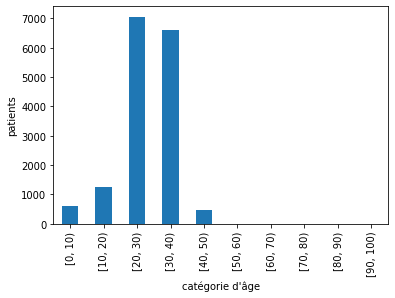

In [131]:
df_patient_age = pd.cut(df_patient.age.dropna(), bins=range(0, 101, 10), right=False)

df_patient_age.value_counts().sort_index().plot.bar(xlabel="catégorie d'âge", ylabel="patients")

In [ ]:
df_patient[df_patient.age < 10].age.value_counts().sort_index().plot.bar(xlabel="âge", ylabel="patients")

On remarquera la présence de quelques patients en très bas âge (inférieur à 6 ans).

Je n'ai pas connaissance d'un quelconque âge minimum pour effectuer un test PCR (à confirmer auprès d'un expert).

### Dates de naissance invalides

La date de naissance est stockée au format `YYYYMMDD` dans une valeur entière.

On la convertit en `datetime` afin de la valider.

In [134]:
dob_datetime = pd.to_datetime(df_patient.date_of_birth, format="%Y%M%d", errors="coerce")


Pour celles qui ne passent pas la conversion, on procède manuellement à l'extraction de l'année, du mois et du jour.

In [ ]:
dob_invalid = (
    df_patient[dob_datetime.isna()].date_of_birth.dropna().astype(str)
        .str.extract(r"(\d{4})(\d{2})(\d{2})", expand=True)
        .rename(columns={0: "year", 1: "month", 2: "day"})
)

dob_invalid.sample(10, random_state=42)

L'échantillon montre la présence de valeurs aberrantes pour le mois et / ou le jour.

Il y a 106 patients pour lesquels la date de naissance est non conforme.

In [137]:
len(dob_invalid)

106

### Incohérence entre date de naissance et âge renseigné

Pour les patients dont la date de naissance est valide, on calcule l'âge en fin d'année 2020.

In [138]:
age_from_dob = (pd.Timestamp("2020-12-31") - dob_datetime).dt.days.floordiv(365.25).rename("age_from_dob")

dob_and_ages = (
    df_patient[["date_of_birth", "age"]]
        .merge(age_from_dob, left_index=True, right_index=True)
        .dropna().convert_dtypes()
)

dob_and_ages.sample(10, random_state=42)

,date_of_birth,age,age_from_dob
6244,19961203,30,24
18566,19831222,30,37
1414,19520202,30,68
11958,19300612,32,90
12137,19281218,32,92
8031,19220313,32,98
5362,19040627,8,116
17012,19441224,31,76
669,19270517,25,93
3307,19460421,22,74


L'échantillon montre une absence de cohérence entre l'âge renseigné et l'âge calculé à partir de la date de naissance.

Même avec une tolérance d'une année, seuls 342 d'entre eux ont un âge cohérent.

In [139]:
from numpy import isclose

isclose(dob_and_ages.age.astype(int), dob_and_ages.age_from_dob.astype(int), atol=1).sum()

342

## Numéro de téléphone

En [Australie](https://info.australia.gov.au/about-australia/facts-and-figures/telephone-country-and-area-codes), les numéro de téléphone sont composés d'un indicatif de zone géographique sur 2 chiffres, suivi d'un indicatif local sur 8 chiffres.

Extraction des indicatifs de zone et locaux.

In [140]:
df_patient_phone_number = df_patient.phone_number.dropna().str.extract(r"(\d{2})\s(\d{8})", expand=True).rename(columns={0: "area", 1: "local"})

df_patient_phone_number.sample(10, random_state=42)

,area,local
19258,08,17943415
18764,02,70246389
2327,03,61091358
15781,07,24114733
2775,02,68865129
8911,07,48179754
18051,07,73663673
15129,08,91409370
9355,02,30368694
3420,03,54790735


Tous les numéro de téléphone renseignés ont un indicatif de zone correct.

In [141]:
df_patient_phone_number.area.isin(["02", "03", "04", "07", "08"]).all()

True

## Adresse personnelle

### Numéro de rue

La numérotation des rues démarrent à 1. Le minimum de 0 est une valeur erronée.

In [142]:
df_patient.street_number.dropna().astype(int).describe()

count     19618.000000
mean         98.812468
std        2481.908686
min           0.000000
25%          10.000000
50%          24.000000
75%          60.000000
max      342951.000000
Name: street_number, dtype: float64

Analyse du nombre de chiffres composant le numéro de rue.

<AxesSubplot:xlabel='digits in street number', ylabel='patients'>

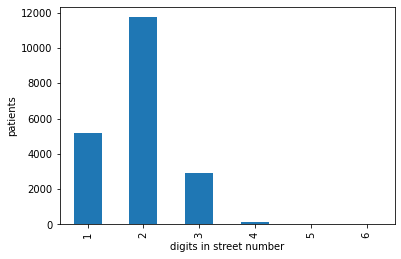

In [143]:
street_number = df_patient.street_number.fillna(0).dropna().astype(int)
street_number["number_of_digits"] = street_number.astype(str).str.len()

street_number.number_of_digits.value_counts().sort_index().plot.bar(xlabel="digits in street number", ylabel="patients")


Il y a quelques patients avec un numéro de rue exceptionnellement élevé (nombre de chiffres >= 5).

On analyse les patients correspondant.

In [144]:
df_patient_with_large_street_number = df_patient.loc[street_number.number_of_digits >= 5]

df_patient_with_large_street_number[["patient_id", "street_number", "address_1", "phone_number"]]

,patient_id,street_number,address_1,phone_number
7055,869217,342951,taylor place,08 37654995
10100,278130,10030,galway place,02 26956185
12440,446997,39430,airey crescent,02 15333991
16287,955542,11575,arrietta close,03 46121237
18456,232871,12569,streeton drive,04 25029200


Les patients ont tous un numéro de téléphone renseigné.

On peut donc effectuer un rapprochement par celui-ci afin d'identifier une possible erreur de saisie.

In [145]:
df = df_patient_with_large_street_number[
    ["patient_id", "street_number", "address_1", "phone_number"]
].merge(
    df_patient[["patient_id", "street_number", "address_1", "phone_number"]],
    on="phone_number"
)
df.loc[df.patient_id_x != df.patient_id_y]

,patient_id_x,street_number_x,address_1_x,phone_number,patient_id_y,street_number_y,address_1_y
0,869217,342951,taylor place,08 37654995,827975,3429,taylor place
1,869217,342951,taylor place,08 37654995,221789,3429,taylor place
3,869217,342951,taylor place,08 37654995,978087,3429,taylor place
4,278130,10030,galway place,02 26956185,893567,1000,galway place
6,278130,10030,galway place,02 26956185,813304,1000,galway place


Le numéro de rue à 6 chiffres est une erreur de saisie (342951 -> 3429).

Idem pour l'un des numéro de rue à 5 chiffres (10030 -> 1000).

### Adresse

#### Taux de remplissage

In [146]:
df_patient[["address_1", "address_2"]].notna().value_counts(normalize=True).sort_index()

address_1  address_2
False      False        0.02325
           True         0.01655
True       False        0.58210
           True         0.37810
dtype: float64

- 96% des adresses ont au moins le premier champ d'adresse renseigné
- 38% ont les deux champs renseignés

#### Fautes de saisie

Rapprochement des adresses de patient partageant un même numéro de téléphone.

In [147]:
address = (
    df_patient[["patient_id", "address_1", "address_2", "phone_number"]]
        .dropna(subset=["phone_number"])
        .fillna("<NA>")
)
address["full_address"] = address[["address_1", "address_2"]].apply(", ".join, axis=1)
address = address.merge(address, on="phone_number")
address = address.loc[
    (address.patient_id_x != address.patient_id_y) & \
    (address.full_address_x != address.full_address_y)
]

address.sort_values(by=["phone_number", "patient_id_x"]).head(10)

,patient_id_x,address_1_x,address_2_x,phone_number,full_address_x,patient_id_y,address_1_y,address_2_y,full_address_y
4194,210155,mcnicollyplace,<NA>,02 00325977,"mcnicollyplace, <NA>",311830,mcnicoll place,<NA>,"mcnicoll place, <NA>"
4196,210155,mcnicollyplace,<NA>,02 00325977,"mcnicollyplace, <NA>",525466,mcnicoll place,<NA>,"mcnicoll place, <NA>"
4192,311830,mcnicoll place,<NA>,02 00325977,"mcnicoll place, <NA>",210155,mcnicollyplace,<NA>,"mcnicollyplace, <NA>"
4198,525466,mcnicoll place,<NA>,02 00325977,"mcnicoll place, <NA>",210155,mcnicollyplace,<NA>,"mcnicollyplace, <NA>"
990,123387,bunurung close,<NA>,02 01272164,"bunurung close, <NA>",505218,bunurunqaqclose,<NA>,"bunurunqaqclose, <NA>"
998,375877,bunurung close,<NA>,02 01272164,"bunurung close, <NA>",505218,bunurunqaqclose,<NA>,"bunurunqaqclose, <NA>"
986,431593,bunurung close,<NA>,02 01272164,"bunurung close, <NA>",505218,bunurunqaqclose,<NA>,"bunurunqaqclose, <NA>"
992,505218,bunurunqaqclose,<NA>,02 01272164,"bunurunqaqclose, <NA>",431593,bunurung close,<NA>,"bunurung close, <NA>"
993,505218,bunurunqaqclose,<NA>,02 01272164,"bunurunqaqclose, <NA>",123387,bunurung close,<NA>,"bunurung close, <NA>"
995,505218,bunurunqaqclose,<NA>,02 01272164,"bunurunqaqclose, <NA>",375877,bunurung close,<NA>,"bunurung close, <NA>"


Calcul de la distance d'édition.

<AxesSubplot:>

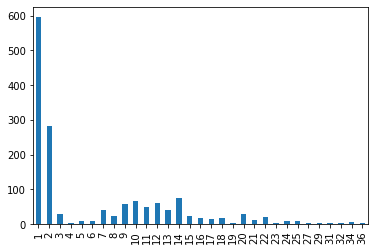

In [148]:
address["distance"] = address.apply(
    lambda x: damerau_levenshtein_distance(x.full_address_x, x.full_address_y),
    axis=1
)

address.distance.value_counts().sort_index().plot.bar()

Fautes typographiques.

In [149]:
address.loc[address.distance <= 2, ["full_address_x", "full_address_y", "distance"]].sample(20, random_state=42)

,full_address_x,full_address_y,distance
3783,"verbrugghen street, <NA>","verbruggheh street, <NA>",1
3027,"wanganeen avenue, <NA>","wanganeemeavenue, <NA>",2
15421,"hannafordastreet, rhosewyn","hannaford street, rhosewyn",1
3682,"sollya place, <NA>","sollya plce, <NA>",1
2648,"goessling place, raffa estate","goessling place, raffa oestate",1
10647,"eldridge street, <NA>","eldridgestreet, <NA>",1
8207,"mclachlan crescent, <NA>","mclachlan cfescent, <NA>",1
5987,"leith place, kieta","leith pnace, kieta",1
16243,"bennetts close, <NA>","bennettsghclose, <NA>",2
623,"millard place, <NA>","millard zlace, <NA>",1


In [150]:
address.loc[address.distance == 3, ["full_address_x", "full_address_y", "distance"]]

,full_address_x,full_address_y,distance
986,"bunurung close, <NA>","bunurunqaqclose, <NA>",3
990,"bunurung close, <NA>","bunurunqaqclose, <NA>",3
992,"bunurunqaqclose, <NA>","bunurung close, <NA>",3
993,"bunurunqaqclose, <NA>","bunurung close, <NA>",3
995,"bunurunqaqclose, <NA>","bunurung close, <NA>",3
998,"bunurung close, <NA>","bunurunqaqclose, <NA>",3
1782,"mccaughey street, narraburra lodge","mccaughey stbeet, narrabburralodge",3
1784,"mccaughey stbeet, narrabburralodge","mccaughey street, narraburra lodge",3
1786,"mccaughey stbeet, narrabburralodge","mccaughey street, narraburra lodge",3
1788,"mccaughey street, narraburra lodge","mccaughey stbeet, narrabburralodge",3


In [151]:
address.loc[address.distance == 4, ["full_address_x", "full_address_y", "distance"]]

,full_address_x,full_address_y,distance
3978,"quirosdtreet, yaroknga","quiros street, yaroonha",4
3982,"quiros street, yaroonha","quirosdtreet, yaroknga",4
4691,"birdwoods reet, <NA>","birdwoosbctreet, <NA>",4
4693,"birdwoosbctreet, <NA>","birdwoods reet, <NA>",4


Autres fautes.


In [152]:
address.loc[address.distance > 4, ["full_address_x", "full_address_y", "distance"]].sample(30, random_state=42)

,full_address_x,full_address_y,distance
1572,"henty street, hillendale","henty street, indra",7
95,"badenoch crescent, golden down","badenoch crescent, <NA>",11
3010,"bragg street, watchorns hill","braggdstreet, <NA>",15
971,"charteris frescent, eagle view","charteris crescent, <NA>",11
13604,"wrixon street, <NA>","john clelanddcrescent, 1st hse past (rhs)",34
3002,"bragg street, watchorns hill","braggdstreet, <NA>",15
8818,"<NA>, rowethorpe trinity hostel","bavin street, rowethorpe trimity hostel",13
3929,"gill stbxeet, burnie north west private hospital","gill street, <NA>",36
1079,"hurleyqatreet, <NA>","kirwan icrcuit, <NA>",11
969,"charteris crescent, <NA>","charteris frescent, eagle view",11


Omission du premier champ d'adresse.

In [153]:
address.loc[8818, ["full_address_x", "full_address_y"]].to_list()

['<NA>, rowethorpe trinity hostel', 'bavin street, rowethorpe trimity hostel']

Omission du second champ d'adresse.

In [154]:
address.loc[940, ["full_address_x", "full_address_y"]].to_list()

['blacket street, rosemount', 'blacket street, <NA>']

Second champ d'adresse différent.

In [155]:
address.loc[1572, ["full_address_x", "full_address_y"]].to_list()

['henty street, hillendale', 'henty street, indra']

Adresse complète différente.

In [156]:
address.loc[3535, ["full_address_x", "full_address_y"]].to_list()

['emery street, <NA>', 'von guerard crescent, <NA>']

### Quartier

#### Taux de remplissage dans l'adresse

In [157]:
df_patient[["suburb", "address_1", "address_2"]].notna().value_counts(normalize=True).sort_index()

suburb  address_1  address_2
False   False      False        0.00025
                   True         0.00005
        True       False        0.00680
                   True         0.00350
True    False      False        0.02300
                   True         0.01650
        True       False        0.57530
                   True         0.37460
dtype: float64

Le quartier est le plus souvent renseigné en complément du premier champ d'adresse.

Il y a quelques rares cas où il est fourni seul, ou avec le second champ d'adresse seulement.

#### Fautes de saisie

Certains couples quartier / postcode ont été inversées lors de la saisie.

In [158]:
df_patient.loc[df_patient.suburb.str.contains(r"\d")]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,full_name
3976,810644,juliana,grosvenor,5,connelly pace,3023,port noarlunga south,tas,19991215,<NA>,03 55227740,<NA>,juliana grosvenor
4080,986559,kirra,choi-lundberg,102,centaurus street,6168,naremburn,vic,19261104,27,08 69584599,<NA>,kirra choi-lundberg
5792,752873,lochlan,blake,258,<NA>,4216,toowoobma,wa,19080821,31,02 84630666,<NA>,lochlan blake
6218,902348,isaac,nakoje,19,collier street,6017,brighton,<NA>,19640421,8,02 69439226,<NA>,isaac nakoje
6618,678110,jaden,green,5,dovey place,3185,oraneg,vic,19151204,23,02 73534391,<NA>,jaden green
9653,690348,andrew,ryan,20,mainwaring rich circuit,3020,blacktown,wa,19760001,22,<NA>,<NA>,andrew ryan
9718,727290,tiffany,loukes,31,leal place,467l0,forest hill,nsw,19760706,23,<NA>,pangani,tiffany loukes
11333,738103,hugi,pascoe,167,leita court,3023,port lincoln,nsw,19040401,<NA>,07 84786511,<NA>,hugi pascoe
14255,684359,sonia,green,50,kalgoorlie crescent,6112,ashfield,sa,<NA>,9,03 46671647,<NA>,sonia green
15479,355033,abby,yoob,243,weston street,3181,forest hill,<NA>,19660615,26,02 68667816,<NA>,abby yoob


Pour ces patients, il faut procéder à l'inversion des valeurs du quartier et du code postal.

Le code postal peut contenir un caractère alphabétique qu'il faudra supprimer (exemple `467l0` -> `4670`).

In [159]:
swapped_suburb_postcode = df_patient.loc[df_patient.suburb.str.contains(r"\d"), ["suburb", "postcode"]]

swapped_suburb_postcode["suburb"], swapped_suburb_postcode["postcode"] = \
    swapped_suburb_postcode["postcode"], swapped_suburb_postcode["suburb"].str.replace(r"[a-z]", "")

df_patient.update(swapped_suburb_postcode)

df_patient.iloc[swapped_suburb_postcode.index]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,full_name
3976,810644,juliana,grosvenor,5,connelly pace,port noarlunga south,3023,tas,19991215,<NA>,03 55227740,<NA>,juliana grosvenor
4080,986559,kirra,choi-lundberg,102,centaurus street,naremburn,6168,vic,19261104,27,08 69584599,<NA>,kirra choi-lundberg
5792,752873,lochlan,blake,258,<NA>,toowoobma,4216,wa,19080821,31,02 84630666,<NA>,lochlan blake
6218,902348,isaac,nakoje,19,collier street,brighton,6017,<NA>,19640421,8,02 69439226,<NA>,isaac nakoje
6618,678110,jaden,green,5,dovey place,oraneg,3185,vic,19151204,23,02 73534391,<NA>,jaden green
9653,690348,andrew,ryan,20,mainwaring rich circuit,blacktown,3020,wa,19760001,22,<NA>,<NA>,andrew ryan
9718,727290,tiffany,loukes,31,leal place,forest hill,4670,nsw,19760706,23,<NA>,pangani,tiffany loukes
11333,738103,hugi,pascoe,167,leita court,port lincoln,3023,nsw,19040401,<NA>,07 84786511,<NA>,hugi pascoe
14255,684359,sonia,green,50,kalgoorlie crescent,ashfield,6112,sa,<NA>,9,03 46671647,<NA>,sonia green
15479,355033,abby,yoob,243,weston street,forest hill,3181,<NA>,19660615,26,02 68667816,<NA>,abby yoob


### État

Répartition des valeurs

In [160]:
state_counts = df_patient.state.value_counts()

On retrouve les codes des 8 états de l'Australie.

In [161]:
state_counts.head(8)

nsw    6189
vic    4382
qld    3548
wa     1598
sa     1397
tas     511
act     250
nt      135
Name: state, dtype: int64

Et 94 autres codes d'état à rectifier.

In [162]:
state_counts[8:]

Series([], Name: state, dtype: int64)

On effectue un premier rapprochement par une distance d'édition très courte.

In [163]:
from itertools import product
from jellyfish import damerau_levenshtein_distance

states = state_counts[:8].index.tolist()
codes = state_counts[8:].index.tolist()

code_to_state = pd.DataFrame(
    data=[damerau_levenshtein_distance(c, s) for c, s in product(codes, states)],
    index=pd.MultiIndex.from_product([codes, states], names=["code", "state"]),
    columns=["distance"],
)

code_to_state = (
    code_to_state[code_to_state.distance == 1]
        .drop(columns="distance")
        .reset_index("code")
        .drop_duplicates("code", keep=False)
        .reset_index()
        .set_index("code")
)["state"]

code_to_state.to_dict()

{}

Correction des états.

In [164]:
df_patient.state.replace(code_to_state.to_dict(), inplace=True)

Liste des codes restant à rapprocher.

In [165]:
state_counts = df_patient.state.value_counts()

state_counts[8:]

Series([], Name: state, dtype: int64)

On constate qu'ils ont tous un code postal renseigné.

In [166]:
invalid_states = state_counts[8:].index.to_list()

df_patient_with_invalid_state = df_patient.loc[df_patient.state.isin(invalid_states)]

df_patient_with_invalid_state[["state", "postcode"]].count()

state       0
postcode    0
dtype: int64

Utilisation d'un service de géocodage pour déduire l'état à partir du code postal.

In [167]:
from geopy.geocoders import Nominatim

geocoder = Nominatim(user_agent="inria-aphp-assignment")
df_patient_with_invalid_state["nominatim"] = df_patient_with_invalid_state.apply(
    lambda row: geocoder.geocode(f"{row.postcode}, australia").address, axis=1)

df_patient_with_invalid_state[["postcode", "state", "nominatim"]].head()

ValueError: Wrong number of items passed 13, placement implies 1

On utilise `geopy` qui fournit une interface commune vers plusieurs services de géocodage, dont Nominatim (OpenStreetMap) qui est gratuit. Des limites de débits d'appliquent et la réponse de l'API est lente, donc il ne faut pas trop en abuser.

On extrait le libellé complet de l'état de l'adresse géocodée par Nominatim et le recode.

In [168]:
df_patient_with_invalid_state["state_from_nominatim"] = (
    df_patient_with_invalid_state.nominatim
        .str.extract(r"(\w[\w\s]*),\s\d{4}", expand=False)
        .str.lower()
        .replace({
            "australian capital territory": "act",
            "queensland": "qld",
            "new south wales": "nsw",
            "northern territory": "nt",
            "south australia": "sa",
            "victoria": "vic",
            "tasmania": "ta",
            "western australia": "wa",
        })
)

df_patient_with_invalid_state[["postcode", "state", "state_from_nominatim"]]

AttributeError: 'DataFrame' object has no attribute 'nominatim'

Correction des états

In [169]:
df_patient.state.iloc[df_patient_with_invalid_state.index] = df_patient_with_invalid_state.state_from_nominatim

AttributeError: 'DataFrame' object has no attribute 'state_from_nominatim'

Validation des états

In [170]:
df_patient.state.value_counts()

nsw    6189
vic    4382
qld    3548
wa     1598
sa     1397
tas     511
act     250
nt      135
Name: state, dtype: int64

Il n'y a plus de codes d'état incorrects.

### Code postal

#### Taux de remplissage dans l'adresse

In [171]:
df_patient[["postcode", "suburb", "state"]].notna().value_counts(sort=False)

postcode  suburb  state
False     False   True         1
          True    False       17
                  True       181
True      False   False       20
                  True       191
          True    False     1953
                  True     17637
dtype: int64

Le code postal est très souvent renseigné, accompagné du quartier et / ou de l'état.   

#### Validation

In [172]:
df_patient.postcode.dropna().str.len().value_counts()

4    19801
Name: postcode, dtype: int64

Chargement du référentiel de codes postaux valides par état.

_Compilé des données de cet [article](https://en.wikipedia.org/w/index.php?title=Postcodes_in_Australia)_

In [192]:
df_state_postcode_range = pd.read_csv("state_postcode.csv").convert_dtypes()

df_state_postcode_range

,state,postcode_min_range,postcode_max_range
0,act,200,299
1,nt,800,999
2,nsw,1000,1999
3,nsw,2000,2599
4,act,2600,2618
5,nsw,2619,2899
6,act,2900,2920
7,nsw,2921,2999
8,vic,3000,3999
9,qld,4000,4999


Codes postaux invalides.

In [194]:
valid_postcode_ranges = pd.arrays.IntervalArray.from_arrays(
    left=df_state_postcode_range.postcode_min_range.astype(int),
    right=df_state_postcode_range.postcode_max_range.astype(int),
    closed="both",
)

df_valid_postcode = pd.Series({
    postcode: valid_postcode_ranges.contains(int(postcode)).any()
    for postcode in df_patient.postcode.dropna().unique()
})

df_valid_postcode[df_valid_postcode == False].index.to_list()

['6798']

Un seul code postal invalide : `6798`.

Codes postaux incohérents avec l'état.

In [242]:
valid_postcode_ranges_per_state = {
    state: pd.arrays.IntervalArray.from_arrays(
        left=postcode.postcode_min_range,
        right=postcode.postcode_max_range,
        closed="both",
    )
    for state, postcode in df_state_postcode.groupby(by="state").agg(tuple).iterrows()
}

df_valid_state_postcode = pd.Series({
    (state, postcode): valid_postcode_ranges_per_state[state].contains(int(postcode)).any()
    for (state, postcode) in df_patient[["state", "postcode"]].dropna().apply(tuple, axis=1).unique()
})

df_valid_state_postcode.value_counts(normalize=True)

False    0.815445
True     0.184555
dtype: float64

Une large proportion de codes postaux sont incohérents avec l'état renseigné. 

In [246]:
df_postcode_state_counts = (
    df_valid_state_postcode.index.to_frame(index=False)
        .set_axis(["state", "postcode"], axis="columns")
        .groupby("postcode").count()
)

(df_postcode_state_counts.state).value_counts(normalize=True).sort_index()

1    0.236224
2    0.163776
3    0.157653
4    0.143367
5    0.168367
6    0.100000
7    0.026531
8    0.004082
Name: state, dtype: float64

Une faible proportion des codes postaux ont une correspondance unique vers l'un des 8 états.